In [1]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

import pandas as pd
import numpy as np

In [2]:
count_file = r'resources\R168X_Neuron_counts.txt'
df_count = pd.read_csv(count_file, sep='\t', index_col=0)
count_df = df_count.transpose()
count_df

gene_id,0610005C13Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610030E20Rik,0610031O16Rik,0610038B21Rik,...,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,ccdc198
WT_rep1,0.0,241.83,4.0,14.0,1795.0,320.0,197.0,398.0,0.0,5.0,...,212.29,433.71,1113.0,3.0,4659.0,5468.0,1908.0,2526.0,0.0,0.0
WT_rep2,0.0,178.00,4.0,13.0,1605.0,278.0,176.0,301.0,0.0,3.0,...,177.37,321.63,866.0,8.0,4028.0,4160.0,1524.0,2096.0,0.0,0.0
WT_rep3,0.0,138.98,3.0,4.0,1102.0,207.0,122.0,253.0,0.0,1.0,...,132.59,279.41,673.0,4.0,3009.0,3154.0,1259.0,1689.0,0.0,0.0
R168X_rep1,0.0,261.95,7.0,13.0,2143.0,289.0,175.0,293.0,0.0,0.0,...,306.60,421.40,965.0,17.0,5872.0,4052.0,2009.0,2934.0,0.0,0.0
R168X_rep2,0.0,228.71,2.0,9.0,1976.0,263.0,161.0,243.0,0.0,1.0,...,231.46,284.54,765.0,11.0,4873.0,2925.0,1560.0,2151.0,0.0,0.0
R168X_rep3,0.0,306.76,6.0,16.0,2725.0,440.0,265.0,313.0,0.0,2.0,...,162.05,335.95,912.0,9.0,5341.0,3298.0,1837.0,2673.0,0.0,0.0


In [3]:
# generate count df in terms of counts-per-million
count_df_cpm = count_df.div(count_df.sum(axis=1), axis=0)*1000000
count_df_cpm.head()

# filter out lowly expressed genes.
# a gene is expressed if it has >=1 cpm count in all collected samples
sel_genes = []
for col in count_df_cpm.columns:
    gene_counts = count_df_cpm[col].values
    if np.count_nonzero(gene_counts>=1)>=len(count_df_cpm):
        sel_genes.append(col)
        
### filter by gene count
count_df_filtered = count_df.loc[:, sel_genes]

print(len(sel_genes))

12575


In [4]:
samples = count_df.index.values

genotype = []
for sample in samples:
    genotype.append(sample.split('_')[0])

clinical_df = pd.DataFrame({'sample':samples, 'genotype':genotype})
clinical_df.set_index('sample', inplace=True)
clinical_df

,genotype
sample,
WT_rep1,WT
WT_rep2,WT
WT_rep3,WT
R168X_rep1,R168X
R168X_rep2,R168X
R168X_rep3,R168X


In [5]:
# make the df integer
for col in count_df_filtered.columns:
    count_df_filtered[col] = count_df_filtered[col].astype(int)

In [6]:
dds = DeseqDataSet(
            counts=count_df_filtered,
            clinical=clinical_df,
            design_factors="genotype",  # compare samples based on the "condition"
            refit_cooks=True,
            n_cpus=16,
        )

In [7]:
dds.deseq2()
stat_res = DeseqStats(dds, n_cpus=16)

stat_res.summary()
result_df = stat_res.results_df

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 5.05 seconds.

Fitting dispersion trend curve...
... done in 2.87 seconds.

Fitting MAP dispersions...
... done in 4.84 seconds.

Fitting LFCs...
... done in 0.60 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.58 seconds.

Log2 fold change & Wald test p-value: genotype WT vs R168X


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
0610009B22Rik,218.916321,-0.226340,0.079717,-2.839290,4.521400e-03,1.194969e-02
0610010F05Rik,1835.107422,-0.316170,0.077950,-4.056059,4.990755e-05,2.147801e-04
0610010K14Rik,293.041992,0.000767,0.151843,0.005051,9.959697e-01,9.967334e-01
0610012G03Rik,178.628128,0.016394,0.154413,0.106170,9.154472e-01,9.425816e-01
0610030E20Rik,299.879700,0.452134,0.068102,6.639076,3.156567e-11,3.891552e-10
...,...,...,...,...,...,...
Zxdc,875.778137,0.287167,0.068483,4.193262,2.749720e-05,1.242909e-04
Zyg11b,4544.047363,-0.178254,0.089569,-1.990130,4.657666e-02,9.020507e-02
Zyx,3847.118164,0.587488,0.130449,4.503597,6.681290e-06,3.416723e-05


In [8]:
result_df['log2FoldChange'] = -result_df['log2FoldChange']

In [9]:
df_gene = pd.read_csv(r'resources/gene_info.csv', index_col=0)
df_gene['position'] = (df_gene['start'] + df_gene['end'])/2

df_rp = pd.read_csv(r"C:\Users\cosmosyw\Documents\Research\Mecp2_v2\results\radial_positions\MOp_majortype_Rp.csv", index_col=0)
df_rp = df_rp[df_rp['majorType']=='Gluta'].copy()
df_rp['chr'] = df_rp['loci_name'].apply(lambda x: x.split('_')[0])
df_rp['start'] = df_rp['loci_name'].apply(lambda x: int(x.split('_')[1]))
df_rp['end'] = df_rp['loci_name'].apply(lambda x: int(x.split('_')[2]))
df_rp['position'] = (df_rp['start'] + df_rp['end'])/2

rps = []

for i, row in df_gene.iterrows():
    df = df_rp[df_rp['chr']==row['chr']].copy()
    if len(df)>0:
        df['distance'] = np.abs(df['position']-row['position'])
        df.sort_values('distance', inplace=True)
        if df['distance'].values[0]>=3000000:
            rps.append(-1)
        else:
            rps.append(df['MOp_RP'].values[0])
    else:
        rps.append(-1)
        
df_gene['radial_position'] = rps

gene_to_rp = {gene:rp for (gene, rp) in zip(df_gene['gene'].values, df_gene['radial_position'].values)}

result_df['gene'] = result_df.index.values
result_df['radial_position'] = result_df['gene'].apply(lambda x: gene_to_rp[x] if x in gene_to_rp.keys() else -1)
result_df = result_df[result_df.radial_position!=-1].copy()
result_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,radial_position
gene_id,,,,,,,,
0610009B22Rik,218.916321,0.226340,0.079717,-2.839290,4.521400e-03,1.194969e-02,0610009B22Rik,0.717041
0610010F05Rik,1835.107422,0.316170,0.077950,-4.056059,4.990755e-05,2.147801e-04,0610010F05Rik,0.797383
0610010K14Rik,293.041992,-0.000767,0.151843,0.005051,9.959697e-01,9.967334e-01,0610010K14Rik,0.603711
0610012G03Rik,178.628128,-0.016394,0.154413,0.106170,9.154472e-01,9.425816e-01,0610012G03Rik,0.672230
0610030E20Rik,299.879700,-0.452134,0.068102,6.639076,3.156567e-11,3.891552e-10,0610030E20Rik,0.793173
...,...,...,...,...,...,...,...,...
Zxdc,875.778137,-0.287167,0.068483,4.193262,2.749720e-05,1.242909e-04,Zxdc,0.727291
Zyg11b,4544.047363,0.178254,0.089569,-1.990130,4.657666e-02,9.020507e-02,Zyg11b,0.685003
Zyx,3847.118164,-0.587488,0.130449,4.503597,6.681290e-06,3.416723e-05,Zyx,0.819426


In [10]:
def get_upper_bound(all_values, bin_size=10):
    percentiles = np.arange(0,100, bin_size)
    percentiles = percentiles + bin_size
    upper_bound = []
    for p in percentiles:
        upper_bound.append(np.percentile(all_values, p))
    upper_bound = np.array(upper_bound)
    return upper_bound

upper_bound = get_upper_bound(result_df['radial_position'].values)
result_df['rp_interval'] = result_df['radial_position'].apply(lambda x: np.argmax(upper_bound>=x))

In [11]:
import matplotlib as mpl

figure_folder = r'figures\mecp2_mutations'

mpl.rc('figure', dpi=300)
mpl.rc('figure', titlesize=9.) 
mpl.rc('figure.constrained_layout', use=True)

mpl.rc('axes', labelsize=7.)
mpl.rc('axes', titlesize=8.)
mpl.rc('axes', linewidth=0.5)

mpl.rc('font', family='Arial')

mpl.rc('savefig', dpi=300)
mpl.rc('savefig', format='pdf')

mpl.rc('xtick', labelsize=6.5)
mpl.rc('xtick.major', size=3)
mpl.rc('xtick.major', width=0.5)

mpl.rc('ytick', labelsize=6.5)
mpl.rc('ytick.major', size=3)
mpl.rc('ytick.major', width=0.5)

mpl.rcParams['pdf.fonttype'] = 42

meta NOT subset; don't know how to subset; dropped


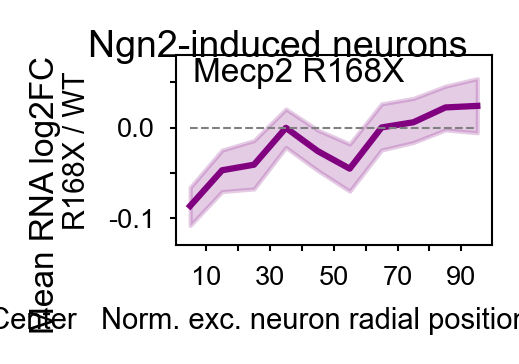

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(1.5,1), dpi=300)

ax1 = fig.add_subplot(111)

sns.lineplot(data=result_df, x='rp_interval', y='log2FoldChange', ax=ax1, color='purple')

ax1.plot([0,9], [0,0], color='gray', linewidth=0.5, linestyle='--')
ax1.set_xticks([])
ax1.set_xlabel('Center   Norm. exc. neuron radial position  Peripheral')
ax1.set_ylabel('R168X / WT')
ax1.set_yticks([-0.1, -0.05, 0, 0.05], [-0.1,'',0.0,''])
ax1.set_ylim(-0.13,0.08)
ax1.text(0.1,0.05, 'Mecp2 R168X', fontsize=8)
ax1.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5],[10,'',30,'',50,'',70,'',90], fontsize=6.5)
ax1.tick_params(axis='both',length=1.5)

fig.supylabel('Mean RNA log2FC', x=-0.05, fontsize=8)
fig.suptitle('Ngn2-induced neurons', y=1.05, fontsize=9)

figure_name = 'Li_R168X.pdf'
plt.savefig(figure_name)

plt.show()